# Learn how to use hax

Aalbers and Tunnell, Feburary 2016

This tutorial describes how to use the basic functionality of the `hax` analysis library from python.

# Table of Contents
 <p><div class="lev1"><a href="#Learn-how-to-use-hax-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Learn how to use hax</a></div><div class="lev2"><a href="#Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2"><a href="#Boilerplate-startup-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Boilerplate startup</a></div><div class="lev1"><a href="#Using-mini-trees-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using mini-trees</a></div><div class="lev2"><a href="#Using-standard-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Using standard data</a></div><div class="lev2"><a href="#Selecting-your-own-variables-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Selecting your own variables</a></div><div class="lev1"><a href="#Looping-over-ROOT-files-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Looping over ROOT files</a></div><div class="lev1"><a href="#Selecting-datasets-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Selecting datasets</a></div>

## Introduction

The default pax output format is a ROOT file containing an event class, which is fully documented [here](http://xenon1t.github.io/pax/format.html). While you could analyze this with TTree.Draw (in python or C++), this has several disadvantages:
  * You never get access to the actual values of the data;
  * It is difficult to compute things that are not directly in the tree;
  * You need to re-loop over the data every time you want to make a new plot.

You can get much more flexibility by looping over the events in the ROOT file(s) you want to analyze (we will cover this in section 3 below). However, looping over all the ROOT events every time you want to adjust a plot or cut is still very inconvenient.

To extract data, hax lets you make **mini-trees**, small, flat ROOT files which contain just the data you need for every event. Since a mini-tree is such a simple (tabular) structure, for python analyses you can read them into a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/10min.html), one of the most-used objects in data science. Since it's the fastest way to the data, we'll cover mini-trees in section 2.

## Boilerplate startup

A jupyter notebook is a complete application, so you always need some startup code, which is usually the same across notebooks. In future we will hide this (since it isn't very exciting), but in case you are interested we go through it here.

First, we importing the math library [numpy](https://en.wikipedia.org/wiki/NumPy)
and the plotting library [matplotlib](https://en.wikipedia.org/wiki/Matplotlib):

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

The command below makes matplotlib plots actually appear in the notebook. By default they are meant to pop-up in a new window, but besides being very inconvenient, this doesn't work if you are accessing a notebook server remotely.

In [2]:
%matplotlib inline 

Next, we set up a few more sensible defaults for matplotlib. In the future we can expand this to our very own XENON plot style...

In [3]:
matplotlib.rc('font', size=16)                   # Use big fonts...
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # ... and big plots

Now it is time to import and intialize `hax`. This may give a "ShimWarning" which you can ignore (we're trying to get rid of this):

In [4]:
import hax
hax.init()

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


You may want to set some special the hax configuration options. For example, use:

    hax.init(main_data_paths=['/path/to/my/secret/data'])
    
to look for datasets in `/path/to/my/secret/data`.

# Using mini-trees

## Using standard data

For basic analyses, you need only some very basic data (s1, s2, positions, etc). You can load this in as follows:

In [10]:
dataset = 'xe100_120404_0804'
data = hax.minitrees.load(dataset)

Created minitree Basics for dataset xe100_120404_0804


You have now loaded in a dataframe with info from the 'Basics' minitree. The **variables and units are documented [here](http://hax.readthedocs.org/en/latest/hax.treemakers.html)**; we can get an overview like so:

In [11]:
data.head(5)

,index,cs1,cs2,dataset_number,drift_time,event_number,event_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z
0,0,NaN,NaN,1204040804,NaN,0,1333519471085856000,0,0,76.219124,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,103.911044,23505.767691,1204040804,39654.324219,1,1333519471119915008,0,0,184.523788,0,5.619877,75.097275,0.241148,21523.064453,0.579082,2.926415,9.900000,-6.860198
2,2,NaN,NaN,1204040804,NaN,2,1333519471141560064,0,0,490.603546,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,47.108560,2698.724570,1204040804,96337.296875,3,1333519471226626048,0,0,2118.838135,0,0.000000,49.550488,0.170977,2178.630371,0.560256,1.183019,6.537736,-16.666353
4,4,3.915421,287.135384,1204040804,51620.585938,4,1333519471326071040,0,0,131.137604,0,5.314155,3.197335,0.000000,256.016388,0.571527,3.549057,-5.292453,-8.930361


Of course you can also make your own minitrees, which we'll discuss below. On disk a minitree is a root file with one branch per column in the table shown above. You could, for example, load this together with the main data tree and friend them, but we will not explore this here.

Now that you have the information in a dataframe, analysis is easy:

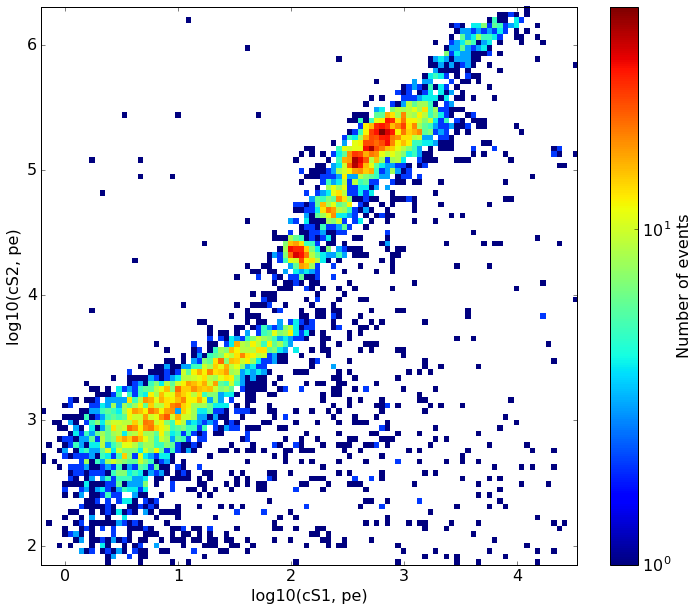

In [12]:
# Require a proper S1
data = data[data['cs1'] > 0]

# Make an S1 vs S2 histogram
plt.hist2d(np.log10(data['cs1']), np.log10(data['cs2']),
           bins=100, 
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')
plt.xlabel('log10(cS1, pe)')
plt.ylabel('log10(cS2, pe)')
plt.show()

## Selecting your own variables

The basic data won't be enough to do all your work. Fortunately, extracting your own minitree with more data is easy: you write a small TreeMaker class defining just one function: `extract_data`. This takes an `event` (the pax/ROOT object documented [here](http://xenon1t.github.io/pax/format.html)) and returns a dictionary with the data you want to save for that event. 

(It's ok if the dictionary is not the same for every event, missing values will become NaNs).

For example, suppose your are interested in the number of hits in the main S1 and S2. You can set up your TreeMaker like so:

In [13]:
class HitsInMainPeaks(hax.minitrees.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['peaks.n_hits']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        return dict(s1_n_hits=s1.n_hits,
                    s2_n_hits=s2.n_hits)

Then you can read in data like this:

In [14]:
data = hax.minitrees.load(dataset, treemakers=[HitsInMainPeaks, 'Basics'])
data.head(5)

Created minitree HitsInMainPeaks for dataset xe100_120404_0804
Found minitree at ./xe100_120404_0804_Basics.root


,index,s1_n_hits,s2_n_hits,index,cs1,cs2,dataset_number,drift_time,event_number,event_time,...,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z
0,0,NaN,NaN,0,NaN,NaN,1204040804,NaN,0,1333519471085856000,...,76.219124,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,44,1489,1,103.911044,23505.767691,1204040804,39654.324219,1,1333519471119915008,...,184.523788,0,5.619877,75.097275,0.241148,21523.064453,0.579082,2.926415,9.900000,-6.860198
2,2,NaN,NaN,2,NaN,NaN,1204040804,NaN,2,1333519471141560064,...,490.603546,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,28,877,3,47.108560,2698.724570,1204040804,96337.296875,3,1333519471226626048,...,2118.838135,0,0.000000,49.550488,0.170977,2178.630371,0.560256,1.183019,6.537736,-16.666353
4,4,2,176,4,3.915421,287.135384,1204040804,51620.585938,4,1333519471326071040,...,131.137604,0,5.314155,3.197335,0.000000,256.016388,0.571527,3.549057,-5.292453,-8.930361


Notice s1_n_hits and s2_n_hits are now part of the dataframe. While you ran the above cell, a file `xe100_120402_2000_s2_n_hits.root` was created in the current directory. The next time you run the cell, the information is taken from this file (which is extremely fast) instead of rebuilt from scratch (which was still pretty fast).

What if you change something in your TreeMaker? You can simply force load() to rebuild your tree:

In [15]:
data = hax.minitrees.load(dataset, treemakers=HitsInMainPeaks, force_reload=True)

Found minitree at ./xe100_120404_0804_HitsInMainPeaks.root
Created minitree HitsInMainPeaks for dataset xe100_120404_0804


A gentler approach is to simply increment the version number of your TreeMaker. `hax` will notice the minitrees are outdated and rebuild them when you try to load your data. (try it!)

# Looping over ROOT files

If you don't like writing your own TreeMaker, or you just want to be 'closer to the ground', you can always just loop over each of the events in the ROOT files themselves. This takes just a few lines of code to setup (look up filename, get TFile, get tree, loop over entries, ....) but hax can save you this small trouble too.

If you define a function, hax will take care of executing it over all events in (one or more) datasets:

In [17]:
help(hax.paxroot.loop_over_dataset)

Help on function loop_over_datasets in module hax.paxroot:

loop_over_datasets(datasets_names, event_function=<function <lambda> at 0x7fc567957ea0>, branch_selection='basic')
    Execute event_function(event) over all events in the dataset(s)
    Does not return anything: you have to keep track of results yourself (global vars, function attrs, classes, ...)
    branch selection: can be None (all branches are read), 'basic' (CONFIG['basic_branches'] are read), or a list of branches to read.



The 'event' your function gets is a pax/ROOT Event object documented [here](http://xenon1t.github.io/pax/format.html#event).

Here is a small (and silly!) example that counts how many events have more than 4 S1s:

In [18]:
counter = 0

def count_many_s1s(event):
    global counter   # Need this in pyton to modify variable outside of function
    if len(event.s1s) > 4:
        counter += 1

hax.paxroot.loop_over_datasets([dataset],
                                count_many_s1s)
print("We found %d events with more than 4 S1s" % counter)

We found 11 events with more than 4 S1s


Another silly example: find the first event whose main s1 area is 70 pe in some dark matter dataset:

In [19]:
def find_s1_70pe(event):
    if not len(event.interactions):
        # Continues to the next event
        # We're in a function, so need to do return rather than continue
        return
    main_interaction = event.interactions[0]
    main_s1 = event.peaks[main_interaction.s1]
    if np.round(main_s1.area) == 70:
        print("Event %s has a main S1 with area %s pe" % (event.event_number, main_s1.area))
        raise hax.paxroot.StopEventLoop    # Special magic that aborts the loop immediately

hax.paxroot.loop_over_dataset(dataset,
                              find_s1_70pe)

  0%|          | 0/17000 [00:00<?, ?it/s]

Event 930 has a main S1 with area 70.06745147705078 pe


# Selecting datasets

For any real analysis you'll want to select several datasets. In the future, hax will interface with the XENON1T run db for you. For now, it just loads some XENON100 runs info, and makes it available as a [pandas dataframe](http://pandas.pydata.org/pandas-docs/stable/10min.html) hax.runs.DATASETS.

(Internally this loads a CSV file, which is copy-pasted from the wiki's runs database table. For now I've only done run 10. Of course for XENON1T we don't want a static csv file, but a connection to the real runs database.)

Here's an example to get all standard AmBe datasets for which we have reprocessed data:

In [20]:
query = 'source == "AmBe" & category == "standard" & tpc == "xenon100" & location != ""'
hax.runs.datasets.query(query)['name'].values

array(['xe100_110210_1100', 'xe100_110210_1412', 'xe100_110211_0532',
       'xe100_120404_0804'], dtype=object)

Of course hax has a shorthand for this:

In [21]:
hax.runs.datasets_query(query)

array(['xe100_110210_1100', 'xe100_110210_1412', 'xe100_110211_0532',
       'xe100_120404_0804'], dtype=object)

For more details on a particular dataset, dig into hax.runs.DATASETS, or use

In [22]:
hax.runs.get_dataset_info('xe100_120402_2000')

{'Unnamed: 16': nan,
 'Unnamed: 17': nan,
 'Unnamed: 18': nan,
 'anode': 4.4000000000000004,
 'category': 'standard',
 'cathode': 16.0,
 'comment': nan,
 'corrected_events': 150000.0,
 'corrected_livetime': 9266.2000000000007,
 'events': 150000,
 'livetime': 9266.25,
 'location': '',
 'name': 'xe100_120402_2000',
 'number': 1204022000,
 'position': 'other',
 'processed': '0.4.5',
 'raw_data_found': True,
 'raw_data_subfolder': 'run_10',
 'run': '10',
 'shield': 'closed',
 'source': 'AmBe',
 'tpc': 'xenon100',
 'trigger': 'S1'}